In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib2

from scipy.interpolate import interp1d

from astropy.io.votable import parse_single_table

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
#Download VOTable files here

#If you run this code with the same source list
#it will overwrite any files with the same name
#as any previous runs.

#Edit sources in this list. 
#Must be strings.
#Prefereably, no spaces.
#If spaces are needed, replace [space] with %20 for correct URL
#Case does not matter.
sources = ['HD101412','HD179218'] 

#############################################
#  Section for adding editted search radii  #
#############################################
#Ensure that radii and sources are the lame length
radii = ['5','5']

if len(sources) != len(radii):
    print "Check your sources and radii list to ensure each have the same number of elements."
    print "Sources length = {} ; Radii length = {}" .format(len(sources),len(radii))

#Can also edit search radius.
#Create new list with radius for each source
#Default is 5 arcseec
for i, source in enumerate(sources):
    response = urllib2.urlopen('http://vizier.u-strasbg.fr/viz-bin/sed?-c='+source+'&-c.rs='+radii[i])
    html = response.read()
    with open(source+".vot", "wb") as code:
        code.write(html)                    #Writes out html string to VOTable format
        

In [3]:
#Define path to your VOTable data file(s).
data_path = ''

#Define data variable and save information to a table.
#THIS IS CASE SENSITIVE. MAKE SURE FILE NAME HAS PROPER CAPITALIZATION
data_orig = parse_single_table(data_path+"HD179218.vot").to_table()

#Create array to store names [Not entirely necessary...]
names = data_orig.colnames

#Define variable from Table of data
freq_orig  = data_orig['sed_freq']   #in GHz
lam_orig   = 299792.458/freq_orig    #convert to microns
flux_orig  = data_orig['sed_flux']   #in Jansky
eflux_orig = data_orig['sed_eflux']  #ERROR in Jansky

#Sort data by ascending Frequency
data = np.sort(data_orig, order='sed_freq')

freq  = data['sed_freq']
lam   = 299792.458/freq
flux  = data['sed_flux']
eflux = data['sed_eflux']

#Any rows with Negative flux values
indexes = [index for index, value in enumerate(data_orig['sed_flux']) if value < 0]
print "{} rows with negative flux values" .format(len(indexes))


#Define plotting variables
freq_min = np.amin(freq)
freq_max = np.amax(freq)
lam_min  = np.amin(lam)
lam_max  = np.amax(lam)


2 rows with negative flux values


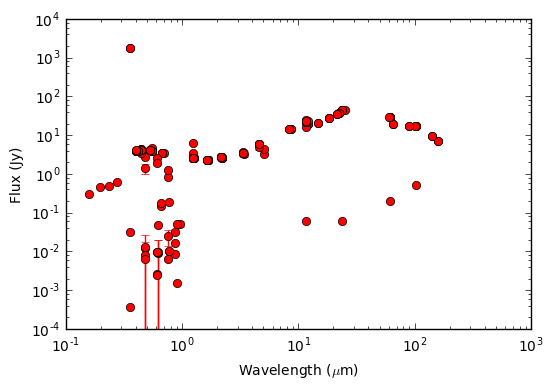

In [4]:
plt.errorbar(lam,flux,yerr=eflux,fmt='ro')
#plt.plot(lam,flux,'ro')   #Plot without error bars

#plt.axis([lam_min/10., lam_max*10., 0.01, 1000.])
plt.xlabel('Wavelength ($\mu$m)')   #Change based on plotting variables
plt.xscale('log')
plt.ylabel('Flux (Jy)')             #Change based on plotting variables
plt.yscale('log')

plt.show()


In [5]:
#Remove ROWS with negative flux values

test = data_orig

indexes = [index for index, value in enumerate(data_orig['sed_flux']) if value < 0]
for index in indexes:
    print(index)  #Prints rows that have negative flux values

test = np.delete(test, (indexes), axis=0)    

print "Original table length {}" .format(len(data_orig))  #To check and see if all
print "New table length {}" .format(len(test))            #rows were removed


156
157
Original table length 211
New table length 209


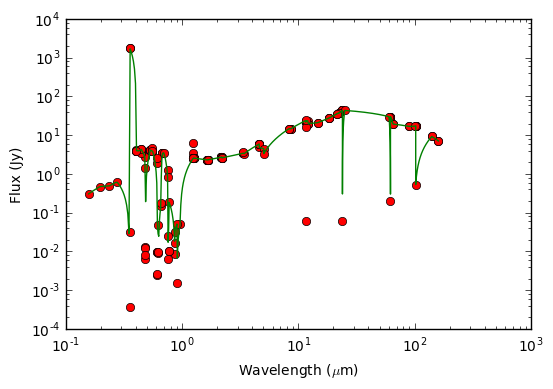

In [6]:
#Sort new table with negative fluxes remooved
#Sort data by ascending Frequency
test2 = np.sort(test, order='sed_freq')

freq_t  = test['sed_freq']
lam_t   = 299792.458/freq_t
flux_t  = test['sed_flux']
eflux_t = test['sed_eflux']


#Fitting a function to the data to interpolate wavenlengths missing from photometry results
#Initial vunction is a simple linear interpolator
fit = interp1d(lam_t,flux_t)

#Plot function
lamnew = np.linspace(lam_min, lam_max, num=20000, endpoint=True)
#plt.errorbar(lam,flux,yerr=eflux,fmt='ro')  #Uncomment to show errorbars
#plt.plot(lamnew, fit(lamnew), 'g-')         #with fit to data
plt.plot(lam_t, flux_t, 'ro', lamnew, fit(lamnew), 'g-')
plt.xlabel('Wavelength ($\mu$m)')
plt.xscale('log')
plt.ylabel('Flux (Jy)')
plt.yscale('log')
plt.show()


In [7]:
min_lam_STR = raw_input("Input minimum wavelength (in microns) ")
min_lam = float(min_lam_STR)
max_lam_STR = raw_input("Input maximum wavelength (in microns) ")
max_lam = float(max_lam_STR)

diff = max_lam - min_lam

low  = min_lam - lam_min  #Testing to make sure input values
high = lam_max - max_lam  #are within the bounds of the data

if diff < 0:
    print "Max wavelength is smaller than min wavelength"
    min_lam = None
    max_lam = None

if low < 0:
    print "Minimum Wavelength is below data range"
    min_lam = None
    max_lam = None

if high < 0:
    print "Maximum Wavelength is above data range"
    min_lam = None
    max_lam = None


Input minimum wavelength (in microns) 2.9
Input maximum wavelength (in microns) 3.0


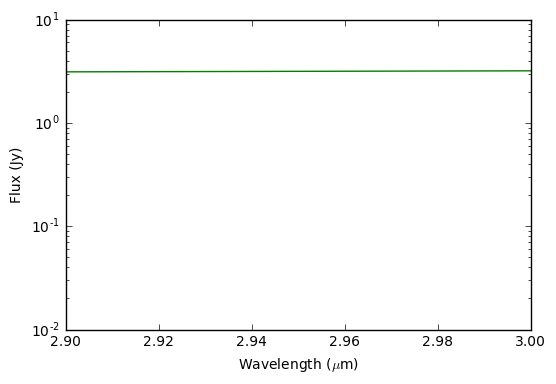

Wavelength (um)    Jansky      erg/s/cm2/um  
2.9059504196 3.11843526982 1.10785159672e-09
2.91394300643 3.12422307514 1.10382743515e-09
2.92193559325 3.13001088046 1.09983066522e-09
2.92992818007 3.13579868578 1.09586101888e-09
2.9379207669 3.1415864911 1.09191823148e-09
2.94591335372 3.14737429642 1.0880020417e-09
2.95390594054 3.15316210174 1.08411219153e-09
2.96189852737 3.15894990706 1.08024842618e-09
2.96989111419 3.16473771237 1.07641049405e-09
2.97788370101 3.17052551769 1.07259814669e-09
2.98587628784 3.17631332301 1.06881113874e-09
2.99386887466 3.18210112833 1.06504922788e-09


In [8]:
plt.errorbar(lam_t,flux_t,yerr=eflux_t,fmt='ro')
plt.plot(lamnew, fit(lamnew), 'g-')

plt.axis([min_lam, max_lam, 0.01, 10.])
plt.xlabel('Wavelength ($\mu$m)')   #Change based on plotting variables
#plt.xscale('log')
plt.ylabel('Flux (Jy)')             #Change based on plotting variables
plt.yscale('log')

plt.show()

print "Wavelength (um)", "   Jansky   ", "  erg/s/cm2/um  "
indexes = [index for index, value in enumerate(lamnew) if value < max_lam and value > min_lam]
for index in indexes:
    print lamnew[index], fit(lamnew[index]), 3.e-9*fit(lamnew[index])/(lamnew[index]*lamnew[index])
